In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
file_data = read_edf(datafile, 'TRIALID')

In [3]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

In [4]:
def saccade(x, x_0, tau, x1, x2, T0, t1, t2, tr):
    
    time = x-T0
    T1 = t1
    T2 = t1+t2
    TR = T2+tr
    
    rho = (tau/T1) * np.log((1+np.exp(T1/tau))/2)
    rhoT = int(np.round(T1*rho))
    
    r = (tau/T2) * np.log((np.exp(T1/tau) + np.exp(T2/tau)) /2)
    rT = int(np.round(T2*r))
    Umax1 = (1/tau) * x1 / ((2*rho-1)*T1 - tau*(2-np.exp(-(rho*T1)/tau) - np.exp((1-rho)*T1/tau)))
    Umax2 = (1/tau) * (x2-x1) / ((2*r-1)*T2-T1)

    xx = []
    
    for t in time :
        if t < 0 :
            xx.append(x_0)
        elif t < rhoT :
            xx.append((x_0 +      Umax1*tau * ((t)    - tau*(1-np.exp(-t/tau)))))
        elif t < T1 :
            xx.append(x_0 + (x1 + Umax1*tau * ((T1-t) + tau*(1-np.exp((T1-t)/tau)))))
        elif t < rT :
            xx.append(x_0 + (x1 + Umax2*tau * ((t-T1) - tau*(1-np.exp(-(t-T1)/tau)))))
        elif t < TR :
            xx.append(x_0 + (x2 + Umax2*tau * ((T2-t) + tau*(1-np.exp((T2-t)/tau)))))
        else :
            xx.append(xx[-1])
    
    return xx

In [5]:
def position(x, bino, start_anti, v_anti, latence, tau, maxi, avant, apres):
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/1000) #/ms # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.fct_exponentiel(x, bino, start_anti, v_anti, latence, tau, maxi)
    pos = np.cumsum(speed)

    for sacc in arg.saccades :
        if sacc[0]-t_0 > int(latence) :
            if int(sacc[1]-t_0)+apres < len(pos) :
                # [starttime, endtime, duration, startx, starty, endx, endy]
                pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = pos[int(sacc[0]-t_0)-avant-1]  #np.nan 
                pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/ arg.px_per_deg) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]
                
            else :
                if int(sacc[0]-t_0)-avant < len(pos) :
                    pos[int(sacc[0]-t_0)-avant:] = pos[int(sacc[0]-t_0)-avant-1]  #np.nan 

 
    return pos

# doing the fit

In [6]:
def Fit_position(velocity_x, trackertime, bino, TargetOn, 
                 StimulusOf, saccades, avant=0, apres=15,
                 param_fit=None, sup=True, time_sup=-280, step=2) :
    

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'v_anti':[0.,-100.,100.],
                   'latence':[TargetOn-t_0+100, TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]} #'v_anti':[0.,-40.,40.]

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]
    
    model = Model(position)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('bino', value=bino, vary=False)
    params.add('avant', value=avant, vary=False)
    params.add('apres', value=apres, vary=False)
    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg

In [7]:
def Fit_saccade(position_x) :

    from lmfit import  Model, Parameters

    model = Model(saccade)

    params = Parameters()
    params.add('x_0', value=position_x[0], vary=False)
    params.add('tau', value=13, min=1, max=40)
    params.add('T0', value=2, min=0, max=len(position_x))
    params.add('t1', value=15, min=10, max=20)#len(position_x))
    params.add('t2', value=20, min=0, max=len(position_x)/2)
    params.add('tr', value=0, min=0, max=10)
    params.add('x1', value=-2, min=-5, max=5)
    params.add('x2', value=-3, min=-5, max=5)

    result_deg = model.fit(position_x, params, x=np.arange(len(position_x)), nan_policy='omit')

    return result_deg

# Residu!

In [8]:
from ANEMO import ANEMO

In [9]:
debut, fin = 0, 25

block = 0
#trial = 13

demi_four, demi_freq = [],[]
four, freq_four = [],[]

for trial in range(10) :
    
    print(trial)

    arg = ANEMO.arg(file_data, file_exp, trial, block)
    trial_data = trial + arg.N_trials*block
    time, t_0 = arg.trackertime, arg.trackertime_0
    start, start1 = arg.TargetOn, arg.TargetOn-t_0
    data_x = arg.data_x -(arg.data_x[arg.StimulusOf-t_0])

    kwarg = {'trackertime' : arg.trackertime, 'bino': arg.bino, 'TargetOn' : arg.TargetOn,
         'StimulusOf':arg.StimulusOf, 'saccades':arg.saccades,
         'param_fit':None,  'avant':debut, 'apres':fin,
         'sup':True, 'time_sup':-280, 'step':2 }
    
    data_1 = np.copy(data_x)/arg.px_per_deg
    data_2 = np.copy(data_1)

    for s in range(len(arg.saccades)):
        data_sacc  = data_1[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin]
        f = Fit_saccade(data_sacc)
        data_2[arg.saccades[s][0]-t_0-debut:arg.saccades[s][1]-t_0+fin] = f.residual+f.values['x_0']

    c = Fit_position(data_2,**kwarg)
    residu = c.residual[start1-700:start1+600]
    
    
    #-----------------------------------------------------------------------------
    ms = 1000.0  # taux d'échantillonnage
    dt = 1.0/ms  # intervalle d'échantillonnage
    n =  len(residu) # longueur du signal
    
    k, T = np.arange(n), n/ms
    frq = k/T # gamme de fréquence de deux côtés
    
    t = np.arange(0,T, dt) # vecteur de temps
    
    N = range(650) #range(int(n/2))
    
    frq = frq[N] # une gamme de fréquence latérale
    freq = np.fft.fftfreq(1300, d=dt)

    fourier = np.fft.fft(residu)/n # fft informatique et normalisation
    
    #-----------------------------------------------------------------------------
    demi_four.append((abs(fourier[N])).tolist())
    four.append(fourier.tolist())
    demi_freq.append(frq.tolist())
    freq_four.append(freq.tolist())

0
1
2
3
4
5
6
7
8
9


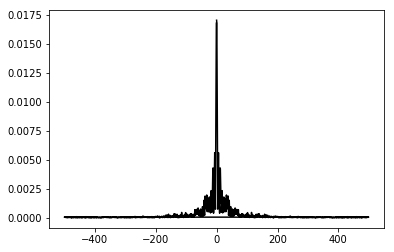

In [10]:
plt.plot(np.mean(freq_four, 0), abs(np.mean(four, 0)), 'k');

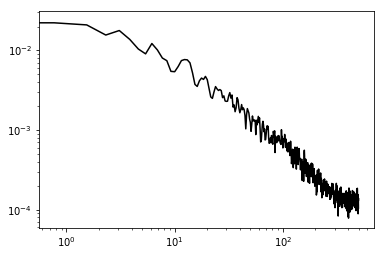

In [12]:
ax = plt.loglog(np.mean(demi_freq, 0), np.mean(demi_four, 0), 'k');